# CNN Model Trained on MNIST Dataset 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

#from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
import os
print(os.listdir('../input'))

['sample_submission.csv', 'train.csv', 'test.csv']


# 2. Data preparation
## 2.1 Load data

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub = pd.read_csv('../input/sample_submission.csv')
print("Data are Ready!!")

Data are Ready!!


In [4]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


**Set data features and labels**

In [5]:
X = train.drop(['label'], 1).values
y = train['label'].values

## 2.2 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [6]:
X = X / 255.0

## 2.3 Reshape

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X = X.reshape(-1,28,28,1)

## 2.4 Label encoding

**One-Hot Encoding**

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (42000, 10)


Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.5 Split training and valdiation set

In [9]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

**Data Visualization**

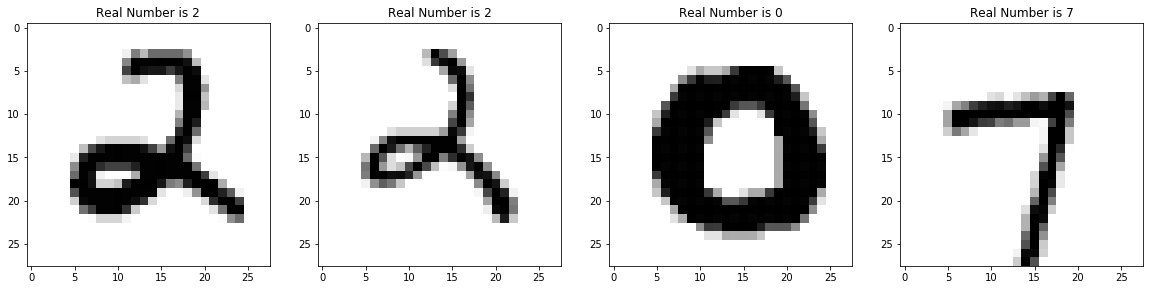

In [11]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

**Normalization**

In [12]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

# 3. CNN
## 3.1 Define the model

**Model Definition**

In [13]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
__________

## 3.2 Data augmentation

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False, 
        rotation_range=15,  
        zoom_range = 0.01, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False, 
        vertical_flip=False)  

train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

## 3.3 Model training

In [17]:
epochs = 10
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [20]:
# Fit the model
history = model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Epoch 1/10
295/295 [==============================] - 9s 31ms/step - loss: 0.1489 - acc: 0.9527 - val_loss: 0.1024 - val_acc: 0.9695
Epoch 2/10
295/295 [==============================] - 9s 29ms/step - loss: 0.0643 - acc: 0.9805 - val_loss: 0.0777 - val_acc: 0.9777
Epoch 3/10
295/295 [==============================] - 8s 29ms/step - loss: 0.0516 - acc: 0.9846 - val_loss: 0.0497 - val_acc: 0.9834
Epoch 4/10
295/295 [==============================] - 9s 29ms/step - loss: 0.0468 - acc: 0.9856 - val_loss: 0.0456 - val_acc: 0.9843
Epoch 5/10
295/295 [==============================] - 8s 28ms/step - loss: 0.0381 - acc: 0.9884 - val_loss: 0.0782 - val_acc: 0.9789
Epoch 6/10
295/295 [==============================] - 8s 29ms/step - loss: 0.0331 - acc: 0.9901 - val_loss: 0.0396 - val_acc: 0.9867
Epoch 7/10
295/295 [==============================] - 8s 28ms/step - loss: 0.0325 - acc: 0.9899 - val_loss: 0.0499 - val_acc: 0.9835
Epoch 8/10
295/295 [==============================] - 9s 29ms/step - 

**Plot CNN model**

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='CNN_model_arch.png', show_shapes=True, show_layer_names=True)

# 4. Evaluate the model
## 4.1 Training and validation curves

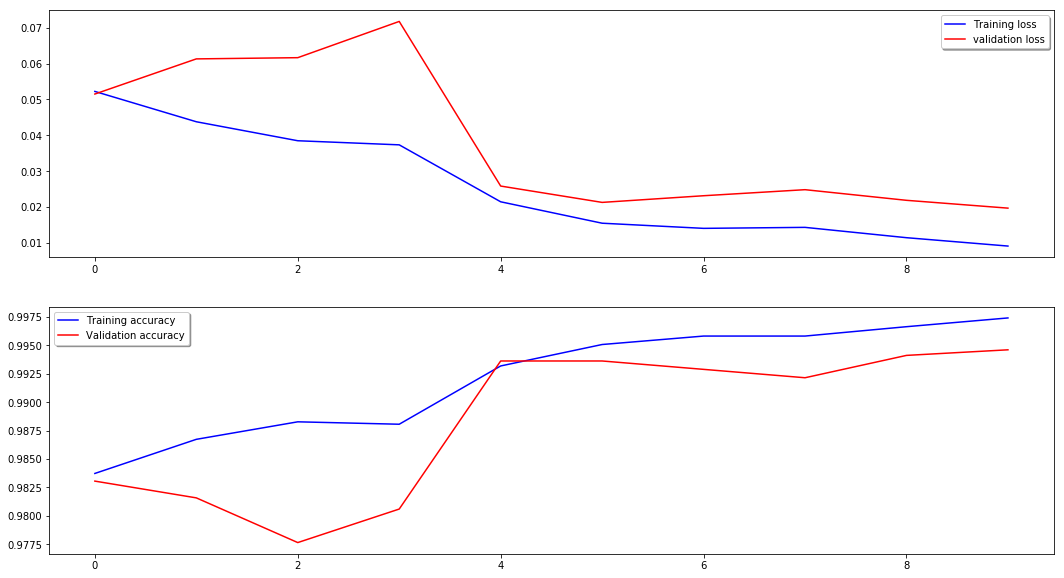

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

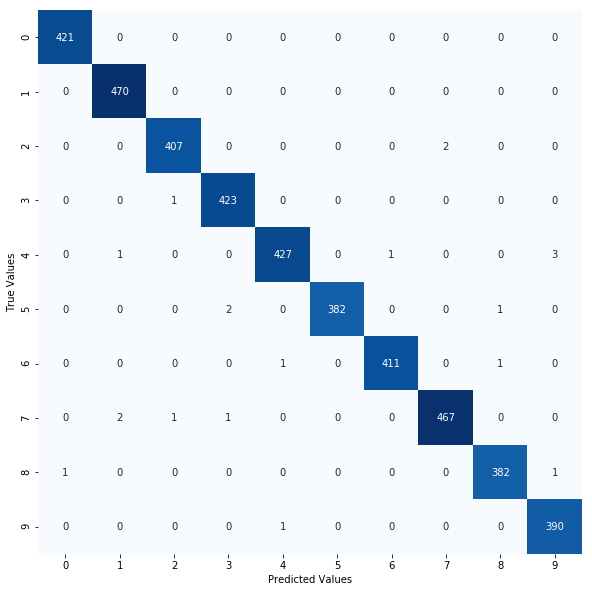

In [23]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

## 5.1 Prediction validation results

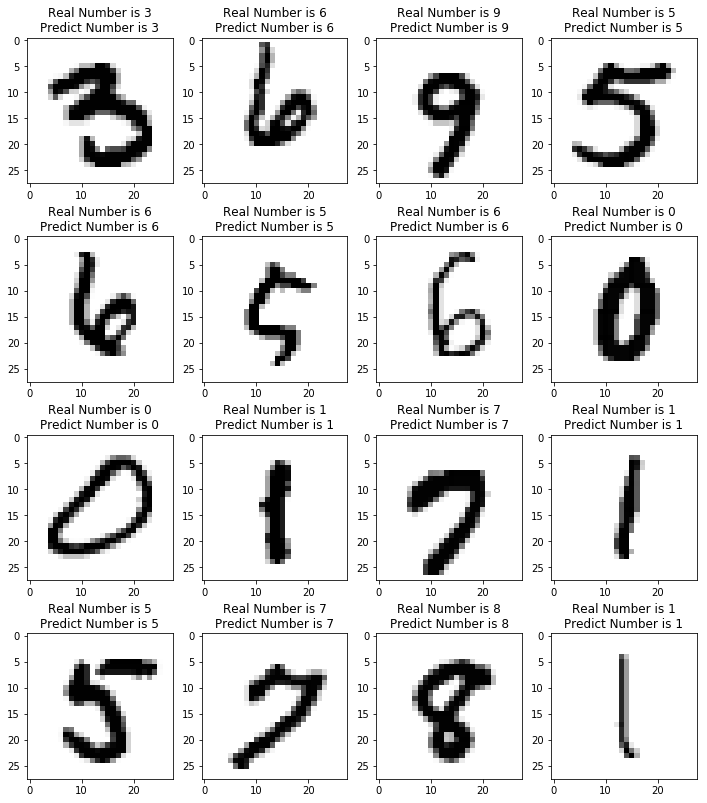

In [24]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

## RLAB Attack

Test Accuracy on Adversarial Examples: 0.1648


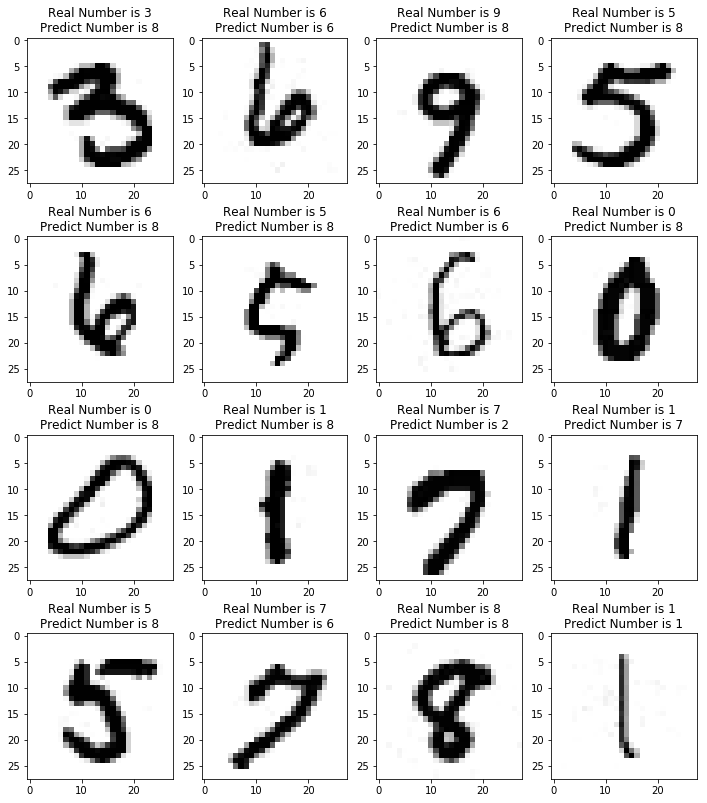

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import median_filter
from tensorflow.keras.models import clone_model

# ----------------------------
# Configuration
# ----------------------------
PATCH_SIZE = 2
NOISE_LEVEL = 0.02 
MAX_STEPS = 5
TOP_K_PATCHES = 10

# ----------------------------
# Patch Functions
# ----------------------------
def get_patches(img, patch_size):
    h, w = img.shape[:2]
    patches = []
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patches.append((i, j))
    return patches

def apply_patch_noise(img, patches, noise_level):
    new_img = img.copy()
    for (i, j) in patches:
        noise = np.random.normal(0, noise_level, (PATCH_SIZE, PATCH_SIZE))
        new_img[i:i+PATCH_SIZE, j:j+PATCH_SIZE] += noise
    return np.clip(new_img, 0, 1)

def l2_dist(img1, img2):
    return np.linalg.norm(img1 - img2)

# ----------------------------
# RLAB Attack
# ----------------------------
def rlab_attack_single(model, original_img, original_label):
    patches = get_patches(original_img, PATCH_SIZE)
    curr_img = original_img.copy()
    prob = model.predict(curr_img.reshape(1, 28, 28, 1))[0][original_label]
    l2_prev = 0

    for step in range(MAX_STEPS):
        patch_scores = []
        for patch in patches:
            temp_img = apply_patch_noise(curr_img, [patch], NOISE_LEVEL)
            pred = model.predict(temp_img.reshape(1, 28, 28, 1))[0]
            new_prob = pred[original_label]
            l2 = l2_dist(original_img, temp_img)
            score = (prob - new_prob) / (l2 - l2_prev + 1e-8)
            patch_scores.append((score, patch))

        patch_scores.sort(reverse=True, key=lambda x: x[0])
        best_patches = [p for _, p in patch_scores[:TOP_K_PATCHES]]
        temp_img = apply_patch_noise(curr_img, best_patches, NOISE_LEVEL)
        pred = model.predict(temp_img.reshape(1, 28, 28, 1))[0]
        new_prob = pred[original_label]
        new_label = np.argmax(pred)
        l2_new = l2_dist(original_img, temp_img)

        curr_img = temp_img
        prob = new_prob
        l2_prev = l2_new

        if new_label != original_label:
            break

    return curr_img

# ----------------------------
# Apply RLAB Attack to Dataset
# ----------------------------
X_test_adv = np.copy(X_test)
for i in range(16):
    orig = X_test[i].reshape(28, 28)
    label = np.argmax(y_test[i])
    X_test_adv[i] = rlab_attack_single(model, orig, label).reshape(28, 28, 1)

# ----------------------------
# Evaluate Model Accuracy on Adversarial Examples
# ----------------------------
test_loss, test_acc = model.evaluate(X_test_adv, y_test, verbose=0)
print(f"Test Accuracy on Adversarial Examples: {test_acc:.4f}")

# ----------------------------
# Display Results
# ----------------------------
y_pred = model.predict(X_test_adv)
X_test__ = X_test_adv.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title=f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}")


### Training with ARBD and applying RLAB

Test Accuracy on Adversarial Examples: 0.9952


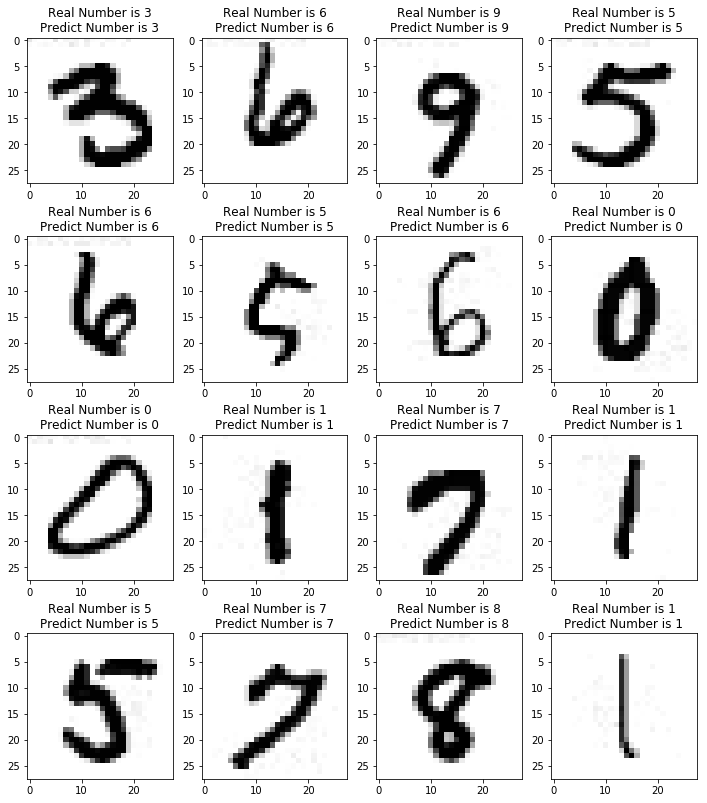

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import median_filter
from tensorflow.keras.models import clone_model

# ----------------------------
# Configuration
# ----------------------------
PATCH_SIZE = 2
NOISE_LEVEL = 0.02 
MAX_STEPS = 5
TOP_K_PATCHES = 10

# ----------------------------
# Patch Functions
# ----------------------------
def get_patches(img, patch_size):
    h, w = img.shape[:2]
    patches = []
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patches.append((i, j))
    return patches

def apply_patch_noise(img, patches, noise_level):
    new_img = img.copy()
    for (i, j) in patches:
        noise = np.random.normal(0, noise_level, (PATCH_SIZE, PATCH_SIZE))
        new_img[i:i+PATCH_SIZE, j:j+PATCH_SIZE] += noise
    return np.clip(new_img, 0, 1)

def l2_dist(img1, img2):
    return np.linalg.norm(img1 - img2)

# ----------------------------
# RLAB Attack
# ----------------------------
def rlab_attack_single(model, original_img, original_label):
    patches = get_patches(original_img, PATCH_SIZE)
    curr_img = original_img.copy()
    prob = model.predict(curr_img.reshape(1, 28, 28, 1))[0][original_label]
    l2_prev = 0

    for step in range(MAX_STEPS):
        patch_scores = []
        for patch in patches:
            temp_img = apply_patch_noise(curr_img, [patch], NOISE_LEVEL)
            pred = model.predict(temp_img.reshape(1, 28, 28, 1))[0]
            new_prob = pred[original_label]
            l2 = l2_dist(original_img, temp_img)
            score = (prob - new_prob) / (l2 - l2_prev + 1e-8)
            patch_scores.append((score, patch))

        patch_scores.sort(reverse=True, key=lambda x: x[0])
        best_patches = [p for _, p in patch_scores[:TOP_K_PATCHES]]
        temp_img = apply_patch_noise(curr_img, best_patches, NOISE_LEVEL)
        pred = model.predict(temp_img.reshape(1, 28, 28, 1))[0]
        new_prob = pred[original_label]
        new_label = np.argmax(pred)
        l2_new = l2_dist(original_img, temp_img)

        curr_img = temp_img
        prob = new_prob
        l2_prev = l2_new

        if new_label != original_label:
            break

    return curr_img

# ----------------------------
# Feature Squeezing (4 bit quatization and 3x3 median filters)
# ----------------------------
def feature_squeeze(img):
    quantized = np.floor(img * 15) / 15.0 
    squeezed = median_filter(quantized, size=3)
    return squeezed

# ----------------------------
# ARBD Training: Adversarial + Feature Squeezing
# ----------------------------
def train_with_arbd(model, X_train, y_train, epochs=5, batch_size=64):
    X_adv_train = np.zeros_like(X_train)
    for i in range(X_train.shape[0]):
        orig = X_train[i].reshape(28, 28)
        label = np.argmax(y_train[i])
        adv_img = rlab_attack_single(model, orig, label)
        X_adv_train[i] = adv_img.reshape(28, 28, 1)

    X_train_combined = np.concatenate([
        feature_squeeze(X_train),
        feature_squeeze(X_adv_train)
    ])
    y_train_combined = np.concatenate([y_train, y_train])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_combined, y_train_combined, epochs=epochs, batch_size=batch_size)
    return model

# ----------------------------
# Apply ARBD Defense
# ----------------------------

train_with_arbd(model, X_train, y_train)

# ----------------------------
# Apply RLAB Attack to Dataset
# ----------------------------
X_test_adv = np.copy(X_test)
for i in range(16):
    orig = X_test[i].reshape(28, 28)
    label = np.argmax(y_test[i])
    X_test_adv[i] = rlab_attack_single(model, orig, label).reshape(28, 28, 1)

# ----------------------------
# Evaluate Model Accuracy on Adversarial Examples
# ----------------------------
test_loss, test_acc = model.evaluate(X_test_adv, y_test, verbose=0)
print(f"Test Accuracy on Adversarial Examples: {test_acc:.4f}")

# ----------------------------
# Display Results
# ----------------------------
y_pred = model.predict(X_test_adv)
X_test__ = X_test_adv.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title=f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}")
